In [1]:
#!/usr/bin/env python
from binance.client import Client
import configparser
import math


class BinanceBot(object):

    """docstring for BinanceInterface"""
    def __init__(self, crypto, fiat):
        self.crypto = crypto
        self.fiat = fiat
        self.symbol = f"{crypto}{fiat}"
        self.configure()

    def configure(self):
        config = configparser.ConfigParser()
        config.read('assets/config.ini')
        api_key = config.get('Binance', 'api_key')
        api_secret = config.get('Binance', 'api_secret')
        self.client = Client(api_key, api_secret)

    def get_all_orders(self):
        return self.client.get_all_orders(symbol=self.symbol)


bot = BinanceBot('BNB', 'BUSD')

In [2]:
from datetime import datetime, timezone
import pandas as pd

data = bot.get_all_orders()
df = pd.DataFrame(data)

In [3]:
df['dt'] = pd.to_datetime(df['time'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('Europe/London')
df.set_index('dt', inplace=True)

df['cummulativeQuoteQty'] = df['cummulativeQuoteQty'].map(float)

In [4]:
import pytz

df_plot = df[
    (df.index >= datetime(2021, 9, 16, tzinfo=timezone.utc)) & 
    (df['status'] == 'FILLED') & 
    (df['side'] == 'SELL')
][['cummulativeQuoteQty']]

its_now = pd.DataFrame(
    [[df_plot.iloc[-1]['cummulativeQuoteQty']]], 
    columns=['cummulativeQuoteQty'],
    index=[datetime.now(pytz.timezone('Europe/London'))]
)

df_plot = df_plot.append(its_now)

stake = df_plot.iloc[0]['cummulativeQuoteQty']

df_plot['cummulativeQuoteQty'] = (df_plot['cummulativeQuoteQty']) / stake

df_plot

,cummulativeQuoteQty
2021-09-20 04:02:23.944000+01:00,1.000000
2021-09-20 08:56:21.847000+01:00,1.019126
2021-09-20 12:28:23.340000+01:00,0.987726
2021-09-20 13:37:21.946000+01:00,1.005799
2021-09-20 13:46:21.934000+01:00,1.024851
2021-09-21 01:19:22.583000+01:00,1.044352
2021-09-21 22:17:22.446000+01:00,1.064753
2021-09-24 10:06:22.127000+01:00,1.031907
2021-09-24 11:52:55.290000+01:00,1.055254
2021-09-25 09:34:22.723000+01:00,1.073014


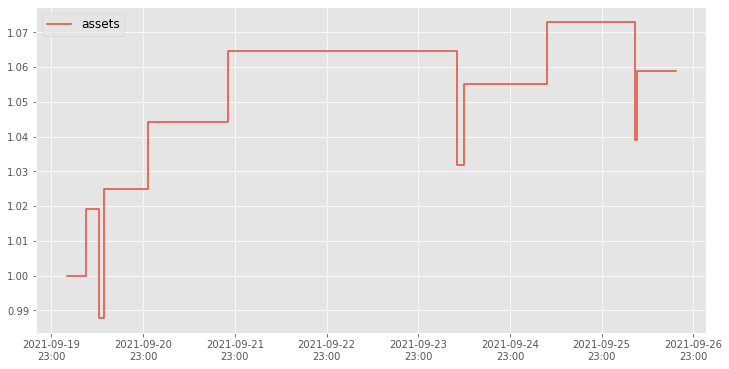

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12, 6)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))

loc = plticker.MultipleLocator(base=0.01)
plt.gca().yaxis.set_major_locator(loc)

plt.plot(df_plot.index, df_plot['cummulativeQuoteQty'], label='assets', drawstyle='steps-post')

plt.legend(loc="best", prop={'size': 12})

plt.savefig('assets/assets.png')